In [1]:
import os
import json
from pathlib import Path

def find_pot_stage_with_most_dates(base_path="../data/nrfa_stations"):
    max_events = 0
    selected_station_id = None
    selected_file_path = None
    base_directory = Path(base_path)
    
    for station_folder in base_directory.iterdir():
        if station_folder.is_dir():
            pot_stage_path = station_folder / "pot-stage.json"
            if pot_stage_path.exists():
                with open(pot_stage_path, "r") as f:
                    pot_stage_data = json.load(f)
                    data_stream = pot_stage_data.get("data-stream", [])
                    num_events = len(data_stream) // 2  # Each event has a date and a value
                    if num_events > max_events:
                        max_events = num_events
                        selected_station_id = station_folder.name
                        selected_file_path = pot_stage_path
                        
    return selected_station_id, selected_file_path, max_events

station_id, file_path, num_events = find_pot_stage_with_most_dates()
if station_id:
    print(f"Station with most events: {station_id} with {num_events} events. File path: {file_path}")
else:
    print("No station found or the path does not exist.")
                    

Station with most events: 47022 with 112 events. File path: ../data/nrfa_stations/47022/pot-stage.json


In [2]:
import pandas as pd
import numpy as np

base_path = "../data/nrfa_stations/" + station_id
files_to_process = ["gdf.json", "cdr.json"]

combined_data = {}

# Process each data stream file
for file_name in files_to_process:
    file_path = Path(base_path) / file_name
    if file_path.exists():
        with open(file_path, "r") as file:
            data = json.load(file)["data-stream"]
            for i in range(0, len(data), 2):  # Step by 2 to get date-value pairs
                date = data[i]
                value = data[i+1]
                if date not in combined_data:
                    combined_data[date] = {}
                combined_data[date][file_name.replace('.json', '')] = value  # Use file name as key, minus '.json'

# Fill missing values for dates that are not present in all data streams
all_dates = sorted(combined_data.keys())
for date in all_dates:
    for file_name in files_to_process:
        key = file_name.replace('.json', '')
        if key not in combined_data[date]:
            combined_data[date][key] = None  # Use None or another strategy for missing values
            
            # Convert the dictionary to a DataFrame for easier handling
df = pd.DataFrame.from_dict(combined_data, orient='index', columns=[f.replace('.json', '') for f in files_to_process])

# Fill or handle missing values in the DataFrame
# For example, fill with zeros, forward fill, etc.
df.fillna(0, inplace=True)  # This example fills missing values with 0

print(df.head())

              gdf  cdr
1979-04-05  0.528    0
1979-04-06  0.562    0
1979-04-07  0.617    0
1979-04-08  0.532    0
1979-04-09  0.577    0


/tmp/ipykernel_96800/2281381624.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)  # This example fills missing values with 0


In [3]:
# Log-transforming a feature
df['gdf_log'] = np.log(df['gdf'] + 1)  # Adding 1 to avoid log(0)

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_sequences(df, n_steps_in, n_steps_out, target_column):
    X, y = [], []
    for i in range(len(df) - n_steps_in - n_steps_out + 1):
        seq_X = df.iloc[i:(i + n_steps_in)].values
        seq_y = df.iloc[(i + n_steps_in):(i + n_steps_in + n_steps_out)][target_column].values
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Assuming 'df' is your DataFrame and 'target_column' is specified correctly
n_steps_in, n_steps_out = 64, 3  # Use 64 days to predict the next 3 days
target_column = 'gdf'  # Specify the target column in your DataFrame
X, y = create_sequences(df, n_steps_in, n_steps_out, target_column)

# Reshape X for scaling: combine samples and timesteps for a 2D shape
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape((n_samples * n_timesteps, n_features))

# Scale the data
scaler_X = MinMaxScaler()
X_scaled_reshaped = scaler_X.fit_transform(X_reshaped)

# Reshape X back to 3D form after scaling
X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# If y is multidimensional and needs scaling, reshape if necessary and scale
if y.ndim > 1:
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)
else:
    y_scaled = y  # No scaling applied if y is already 1D

print(X_scaled.shape, y_scaled.shape)
print(X_scaled[0], y_scaled[0])

(8343, 64, 3) (8343, 3)
[[0.08848394 0.         0.20499424]
 [0.09487131 0.         0.21723596]
 [0.10520383 0.         0.2364855 ]
 [0.08923539 0.         0.2064485 ]
 [0.09768927 0.         0.22255224]
 [0.1095247  0.         0.24434187]
 [0.09637423 0.         0.22007763]
 [0.08773248 0.         0.20353616]
 [0.07890287 0.         0.18611119]
 [0.08416307 0.         0.19655762]
 [0.08979899 0.         0.20753671]
 [0.0839752  0.         0.19618789]
 [0.07439414 0.         0.17699826]
 [0.08021792 0.         0.18874124]
 [0.06763104 0.         0.16304267]
 [0.07270336 0.         0.17354205]
 [0.08416307 0.         0.19655762]
 [0.09148976 0.         0.21078862]
 [0.10839752 0.         0.24230305]
 [0.06424948 0.         0.15593135]
 [0.09017471 0.         0.208261  ]
 [0.06086793 0.         0.14872793]
 [0.05974075 0.         0.14630591]
 [0.06161939 0.         0.15033677]
 [0.05767424 0.         0.14183797]
 [0.06462521 0.         0.156726  ]
 [0.06631599 0.         0.16028795]
 [0.

In [22]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure the ratios sum up to 1
    assert (train_ratio + val_ratio + test_ratio) == 1
    
    # Calculate split indices
    total_samples = len(X)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)
    
    # Split the data
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Split the data
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_scaled, y_scaled)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (5840, 64, 3), (5840, 3)
Validation set: (1251, 64, 3), (1251, 3)
Test set: (1252, 64, 3), (1252, 3)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False), # Set return_sequences=True for stacked LSTMs
    Dropout(0.2),
    Dense(n_steps_out, activation="softmax")
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for classification

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size=32)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

Epoch 1/10
183/183 [==============================] - 2s 10ms/step - loss: 0.3320 - accuracy: 0.3620 - val_loss: 0.3042 - val_accuracy: 0.4468
Epoch 2/10
183/183 [==============================] - 1s 8ms/step - loss: 0.3347 - accuracy: 0.3560 - val_loss: 0.3063 - val_accuracy: 0.4468
Epoch 3/10
183/183 [==============================] - 1s 8ms/step - loss: 0.3347 - accuracy: 0.3560 - val_loss: 0.3043 - val_accuracy: 0.4468
Epoch 4/10
183/183 [==============================] - 1s 8ms/step - loss: 0.3354 - accuracy: 0.3495 - val_loss: 0.3057 - val_accuracy: 0.4468
Epoch 5/10
183/183 [==============================] - 1s 8ms/step - loss: 0.3331 - accuracy: 0.3548 - val_loss: 0.3043 - val_accuracy: 0.4468
Epoch 6/10
183/183 [==============================] - 1s 8ms/step - loss: 0.3337 - accuracy: 0.3579 - val_loss: 0.3048 - val_accuracy: 0.4468
Epoch 7/10
183/183 [==============================] - 1s 7ms/step - loss: 0.3343 - accuracy: 0.3481 - val_loss: 0.3035 - val_accuracy: 0.4468
Epoch

40/40 [==============================] - 0s 9ms/step


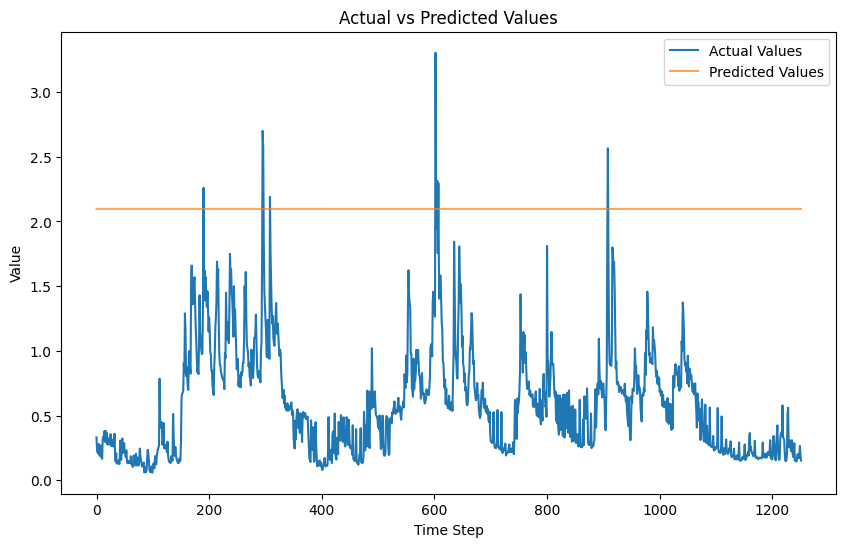

In [27]:
# Generate predictions
y_pred_scaled = model.predict(X_test)

# Assuming you've scaled your target variable 'y' and you have the scaler object available
# Inverse transform the predictions
# Note: Adjust 'y_pred_scaled' and 'y_test' transformation according to your scaling approach
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Adjust this line based on your scaler
y_actual = scaler_y.inverse_transform(y_test)  # Adjust this line based on your scaler

# Plotting
import matplotlib.pyplot as plt

# Plot the first n predictions
n = 400  # Number of predictions to plot
time_steps = range(n)

# Assuming 'predictions' shape is [num_samples, n_output]
# Here, we plot only the first prediction for each sample
plt.figure(figsize=(10, 6))
plt.plot(y_actual[:, 0], label='Actual Values')  # Assuming 'actuals' matches the first prediction timeline
plt.plot(y_pred[:, 0], label='Predicted Values', alpha=0.7)  # Only the first step of each prediction
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

